In [1]:
!pip install vit_keras tensorflow_addons natsort

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model

from vit_keras import vit

from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from natsort import natsorted

2024-04-25 04:26:41.522785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 04:26:41.522912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 04:26:41.688803: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class CONFIG:
    IMG_SIZE = 224, 224
    BATCH_SIZE = 64
    SEED = 9
    AUTO = tf.data.AUTOTUNE

# <span style="color:#e74c3c;"> Reading </span> Data

In [4]:
def create_images_list(path):
    full_path = []
    images = natsorted(os.listdir(path))
    for i in images:
        if i == 'desktop.ini': 
            pass
        else:
            full_path.append(os.path.join(path, i))
    return full_path


def create_full_img_class_df(full_path):
    full_images_path = create_images_list(full_path)
    
    data = pd.DataFrame()
    img_rows = []
    label_rows = []
    
    for i in range(len(full_images_path)):
        x = create_images_list(full_images_path[i])
        img_rows.extend(x)
        label_rows.extend([i+1]*len(x))
    
    data['image'] = img_rows
    data['label'] = label_rows
    
    return data


classes = {1: '1_Subol_Lota', 2: '2_Bashmoti', 3: '3_Ganjiya', 4: '4_Shampakatari', 5: '5_Katarivog', 6: '6_BR28', 7: '7_BR29', 8: '8_Paijam', 9: '9_Bashful', 10: '10_Lal_Aush', 11: '11_Jirashail', 12: '12_Gutisharna', 13: '13_Red_Cargo', 14: '14_Najirshail', 15: '15_Katari_Polao', 16: '16_Lal_Biroi', 17: '17_Chinigura_Polao', 18: '18_Amon', 19: '19_Shorna5', 20: '20_Lal_Binni'}


train_data = create_full_img_class_df('/kaggle/input/aruzz22-5k-an-image-dataset-of-rice-varieties/1_TRAIN')
test_data = create_full_img_class_df('/kaggle/input/aruzz22-5k-an-image-dataset-of-rice-varieties/2_VALID')

train_data = train_data.sample(frac = 1, ignore_index = True, random_state = CONFIG.SEED)
test_data = test_data.sample(frac = 1, ignore_index = True, random_state = CONFIG.SEED)

print('total train images \t{0}'.format(train_data.shape[0]))
print('total test images \t{0}'.format(test_data.shape[0]))

total train images 	22500
total test images 	4500


In [5]:
train_data.head()

,image,label
0,/kaggle/input/aruzz22-5k-an-image-dataset-of-r...,9
1,/kaggle/input/aruzz22-5k-an-image-dataset-of-r...,6
2,/kaggle/input/aruzz22-5k-an-image-dataset-of-r...,14
3,/kaggle/input/aruzz22-5k-an-image-dataset-of-r...,10
4,/kaggle/input/aruzz22-5k-an-image-dataset-of-r...,10


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [6]:
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, (CONFIG.IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label

In [7]:
train_loader = tf.data.Dataset.from_tensor_slices((train_data['image'], train_data['label']))
train_dataset = (train_loader.map(img_preprocessing, num_parallel_calls = CONFIG.AUTO)
                 .batch(CONFIG.BATCH_SIZE).prefetch(CONFIG.AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_data['image'], test_data['label']))
test_dataset = (test_loader.map(img_preprocessing, num_parallel_calls = CONFIG.AUTO)
                 .batch(CONFIG.BATCH_SIZE).prefetch(CONFIG.AUTO))

# <span style="color:#3498db;"> Feature Extraction </span>

# <span style="color:#e74c3c;"> Pretrained ViT Model Feature Extractor </span>

In [8]:
stg = tf.distribute.MirroredStrategy()

In [9]:
from vit_keras import vit

with stg.scope():
    vit_model = vit.vit_b16(image_size = CONFIG.IMG_SIZE, activation = 'softmax', pretrained = True, include_top = False, pretrained_top = False, classes = 20)

    inp = Input(shape = (*CONFIG.IMG_SIZE, 3))
    vit = vit_model(inp)
    X = Flatten()(vit)
    out = Dense(256, activation = 'gelu', name = 'the_feature_layer')(X)

    feature_extractor_model = Model(inputs = inp, outputs = out)
    
    feature_extractor_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['acc'] )
    feature_extractor_model.summary()

347502902/347502902 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 the_feature_layer (Dense)   (None, 256)               196864    
                                                                 
Total params: 85995520 (328.05 MB)
Trainable params: 85995520 (328.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
train_img_features = feature_extractor_model.predict(train_dataset)

352/352 [==============================] - 150s 399ms/step


# <span style="color:#e74c3c;"> Dimensionality </span> Reduction

In [11]:
pca_ = PCA(217)
pca_opt = pca_.fit(train_img_features)

train_img_final_features = pca_opt.transform(train_img_features)

train_img_final_features.shape

(22500, 217)

In [12]:
new_feature_column_names = []
for i in range(train_img_final_features.shape[1]):
    new_feature_column_names.append('feature_{0}'.format(i+1))
    
train_features = pd.DataFrame(train_img_final_features, columns = new_feature_column_names)


train_features.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217
0,0.857710,4.172801,-0.422713,-0.401834,-2.109674,0.083848,-1.621919,0.640407,-0.906493,0.443252,...,-0.095439,-0.285131,-0.107434,0.204086,-0.056876,0.141653,0.135409,0.140686,0.033206,-0.008209
1,-4.479178,-0.278564,-1.864883,0.976407,1.493302,-1.389767,0.596663,0.376164,-1.250523,0.247866,...,0.005058,-0.148541,0.177336,0.097896,0.034192,0.042366,-0.023809,0.038236,0.060497,0.009334
2,-0.947152,1.187656,0.004810,-1.609351,1.603720,2.754796,-0.196760,-1.049494,-1.766607,-0.787919,...,0.156472,-0.077211,-0.087448,-0.058661,0.164743,0.060749,0.036119,-0.120805,-0.137207,0.065901
3,4.986636,-1.672617,2.796919,1.174133,2.424453,-0.412560,-1.358722,2.880275,0.256743,0.416593,...,0.354119,0.163089,-0.555432,-0.400408,0.300358,0.113959,0.097403,0.039951,-0.124608,0.013751
4,2.669749,-0.392445,4.280591,1.545447,1.496622,-1.107963,-0.330883,-1.086634,-0.432462,-0.145180,...,-0.032390,-0.178378,0.509780,-0.114900,-0.226617,0.146067,0.176558,0.165534,0.184785,0.173985


In [14]:
X_train = train_features
y_train =  train_data['label']

with stg.scope():
     test_features = feature_extractor_model.predict(test_dataset)

test_features = pca_opt.transform(test_features)
test_features = pd.DataFrame(test_features, columns = new_feature_column_names)


X_test = test_features
y_test = test_data['label']

71/71 [==============================] - 29s 403ms/step


# <span style="color:#e74c3c;"> Classification SVC </span> Model

In [16]:
SVC_model = SVC(kernel = 'rbf')
SVC_model.fit(X_train, y_train)
test_pred = SVC_model.predict(X_test)

In [25]:
mse = mean_squared_error(y_test, test_pred)
f1 = f1_score(y_test, test_pred, average = 'weighted')
acc_svc = accuracy_score(y_test, test_pred)

print('Mean Squared Error :\t{0:.5f}'.format(mse))
print('Weighted F1 Score :\t{0:.3f}'.format(f1))
print('Accuracy Score :\t{0:.3f} %'.format(acc_svc*100))

Mean Squared Error :	1.75244
Weighted F1 Score :	0.946
Accuracy Score :	94.600 %


In [26]:
clf_report = classification_report(y_test, test_pred, target_names = list(classes.values()))
print(clf_report)

                    precision    recall  f1-score   support

      1_Subol_Lota       0.96      0.96      0.96       225
        2_Bashmoti       0.99      0.98      0.99       225
         3_Ganjiya       1.00      0.98      0.99       225
    4_Shampakatari       0.94      0.91      0.92       225
       5_Katarivog       0.93      0.93      0.93       225
            6_BR28       0.83      0.88      0.86       225
            7_BR29       0.91      0.90      0.90       225
          8_Paijam       0.77      0.88      0.82       225
         9_Bashful       0.98      0.97      0.98       225
       10_Lal_Aush       1.00      1.00      1.00       225
      11_Jirashail       0.86      0.84      0.85       225
     12_Gutisharna       0.87      0.77      0.82       225
      13_Red_Cargo       1.00      1.00      1.00       225
     14_Najirshail       0.99      0.98      0.98       225
   15_Katari_Polao       0.96      0.96      0.96       225
      16_Lal_Biroi       1.00      1.00

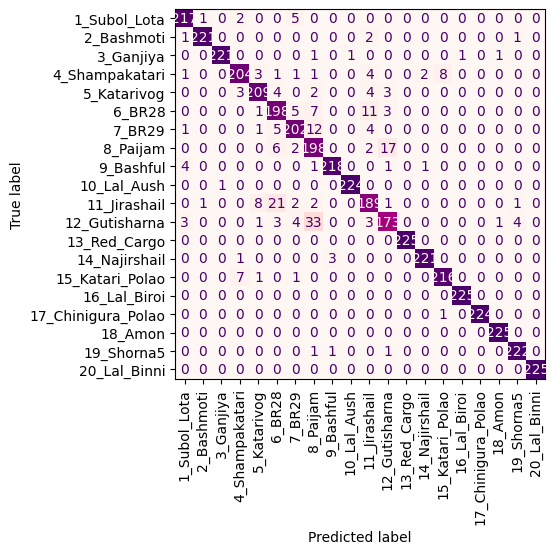

In [27]:
cmd = ConfusionMatrixDisplay.from_predictions(y_test,test_pred,display_labels = list(classes.values()), xticks_rotation = 'vertical',cmap = 'RdPu', colorbar = False)
plt.show()

# <span style="color:#e74c3c;"> Classification Random Forest</span> Model

In [28]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(n_estimators=10, random_state=42)

RF_model.fit(X_train, y_train)

test_pred_RF = RF_model.predict(X_test)

In [29]:
mse_RF = mean_squared_error(y_test, test_pred_RF)
f1_RF = f1_score(y_test, test_pred_RF, average='weighted')
acc_RF = accuracy_score(y_test, test_pred_RF)

print('Random Forest Model Metrics:')
print('Mean Squared Error :\t{0:.5f}'.format(mse_RF))
print('Weighted F1 Score :\t{0:.3f}'.format(f1_RF))
print('Accuracy Score :\t{0:.3f} %'.format(acc_RF * 100))

Random Forest Model Metrics:
Mean Squared Error :	4.50400
Weighted F1 Score :	0.928
Accuracy Score :	92.800 %


In [33]:
clf_report = classification_report(y_test, test_pred_RF, target_names = list(classes.values()))
print(clf_report)

                    precision    recall  f1-score   support

      1_Subol_Lota       0.84      0.94      0.89       225
        2_Bashmoti       0.92      0.96      0.94       225
         3_Ganjiya       0.96      0.95      0.96       225
    4_Shampakatari       0.87      0.96      0.91       225
       5_Katarivog       0.91      0.96      0.93       225
            6_BR28       0.88      0.95      0.91       225
            7_BR29       0.90      0.92      0.91       225
          8_Paijam       0.85      0.91      0.88       225
         9_Bashful       0.95      0.94      0.95       225
       10_Lal_Aush       0.95      0.97      0.96       225
      11_Jirashail       0.93      0.94      0.93       225
     12_Gutisharna       0.88      0.76      0.81       225
      13_Red_Cargo       0.98      0.97      0.97       225
     14_Najirshail       0.94      0.78      0.85       225
   15_Katari_Polao       0.97      0.90      0.93       225
      16_Lal_Biroi       0.97      0.94

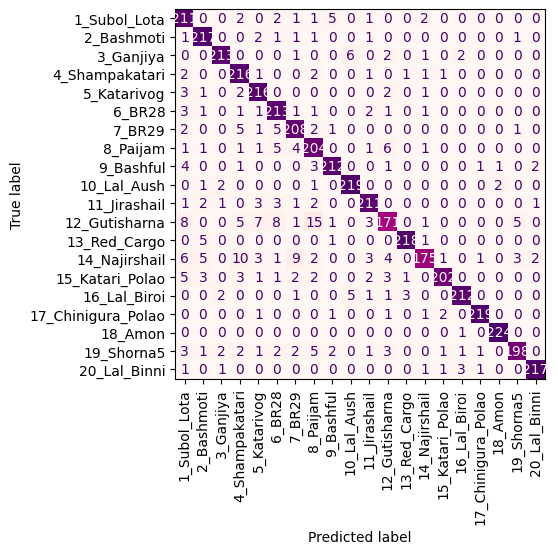

In [34]:
cmd = ConfusionMatrixDisplay.from_predictions(y_test,test_pred_RF,display_labels = list(classes.values()), xticks_rotation = 'vertical',cmap = 'RdPu', colorbar = False)
plt.show()

# <span style="color:#e74c3c;"> Classification Logistic Regression</span> Model

In [35]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression(max_iter=1000)

LR_model.fit(X_train, y_train)

test_pred_LR = LR_model.predict(X_test)

In [36]:
mse_LR = mean_squared_error(y_test, test_pred_LR)
f1_LR = f1_score(y_test, test_pred_LR, average='weighted')
acc_LR = accuracy_score(y_test, test_pred_LR)

print('Logistic Regression Model Metrics:')
print('Mean Squared Error :\t{0:.5f}'.format(mse_LR))
print('Weighted F1 Score :\t{0:.3f}'.format(f1_LR))
print('Accuracy Score :\t{0:.3f} %'.format(acc_LR * 100))

Logistic Regression Model Metrics:
Mean Squared Error :	3.88378
Weighted F1 Score :	0.893
Accuracy Score :	89.311 %


In [37]:
clf_report = classification_report(y_test, test_pred_LR, target_names = list(classes.values()))
print(clf_report)

                    precision    recall  f1-score   support

      1_Subol_Lota       0.91      0.92      0.92       225
        2_Bashmoti       0.98      0.98      0.98       225
         3_Ganjiya       0.96      0.96      0.96       225
    4_Shampakatari       0.83      0.80      0.82       225
       5_Katarivog       0.85      0.88      0.86       225
            6_BR28       0.74      0.73      0.74       225
            7_BR29       0.77      0.77      0.77       225
          8_Paijam       0.66      0.71      0.68       225
         9_Bashful       0.97      0.96      0.97       225
       10_Lal_Aush       0.98      0.97      0.98       225
      11_Jirashail       0.77      0.71      0.74       225
     12_Gutisharna       0.73      0.69      0.71       225
      13_Red_Cargo       1.00      1.00      1.00       225
     14_Najirshail       0.92      0.93      0.93       225
   15_Katari_Polao       0.90      0.92      0.91       225
      16_Lal_Biroi       0.98      0.99

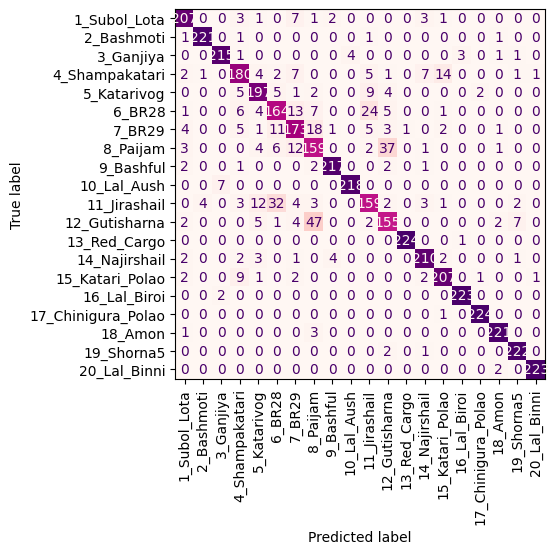

In [38]:
cmd = ConfusionMatrixDisplay.from_predictions(y_test,test_pred_LR,display_labels = list(classes.values()), xticks_rotation = 'vertical',cmap = 'RdPu', colorbar = False)
plt.show()

# <span style="color:#e74c3c;"> Comparion of</span> Models

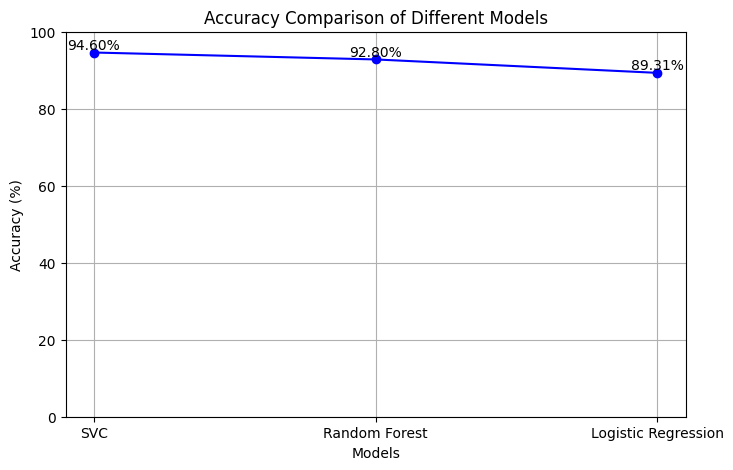

In [51]:
import matplotlib.pyplot as plt

model_names = ['SVC', 'Random Forest', 'Logistic Regression']
accuracies = [acc_svc*100, acc_RF*100, acc_LR*100]


plt.figure(figsize=(8, 5))
plt.plot(model_names, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison of Different Models')
plt.ylim(0, 100)
plt.grid(True)  

for i, acc in enumerate(accuracies):
    plt.text(model_names[i], acc, f'{acc:.2f}%', ha='center', va='bottom')

plt.show()


# <span style="color:#e74c3c;"> Test Sample</span> Prediction

In [39]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)


def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(test_pred))[:5]
    batch_idx = idxs // CONFIG.BATCH_SIZE
    image_idx = idxs-batch_idx * CONFIG.BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(test_pred[idx[i]]) == label:
            axs[i].imshow(img, cmap = 'gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img,  cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'red')

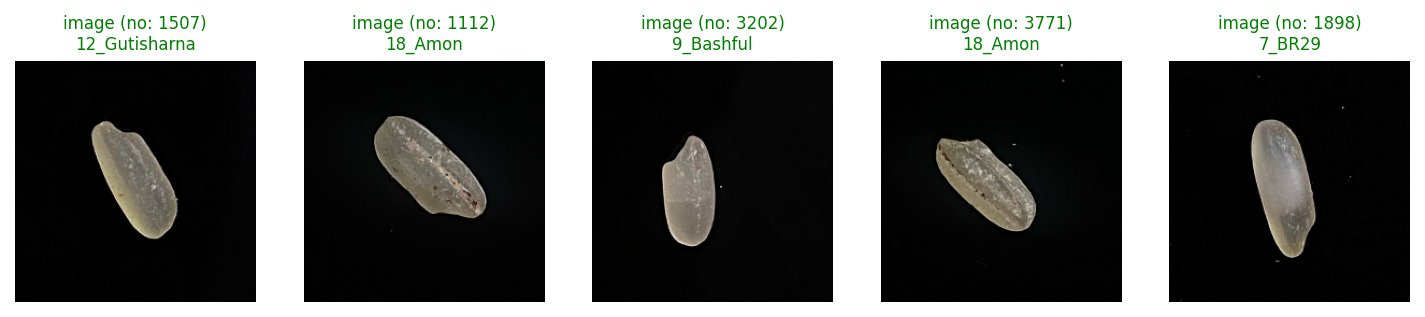

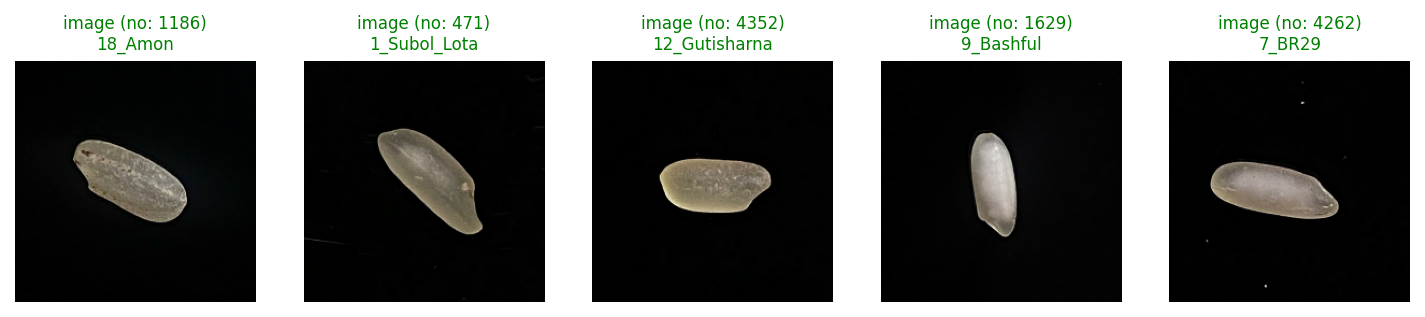

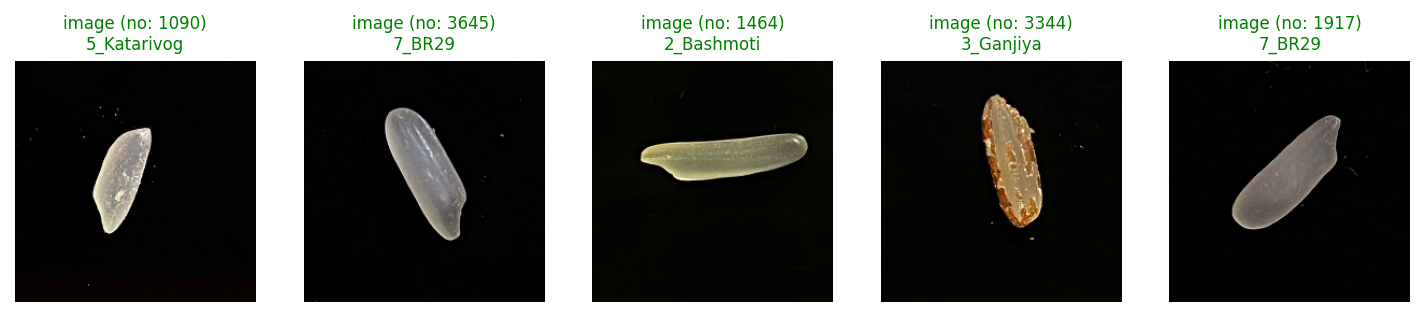

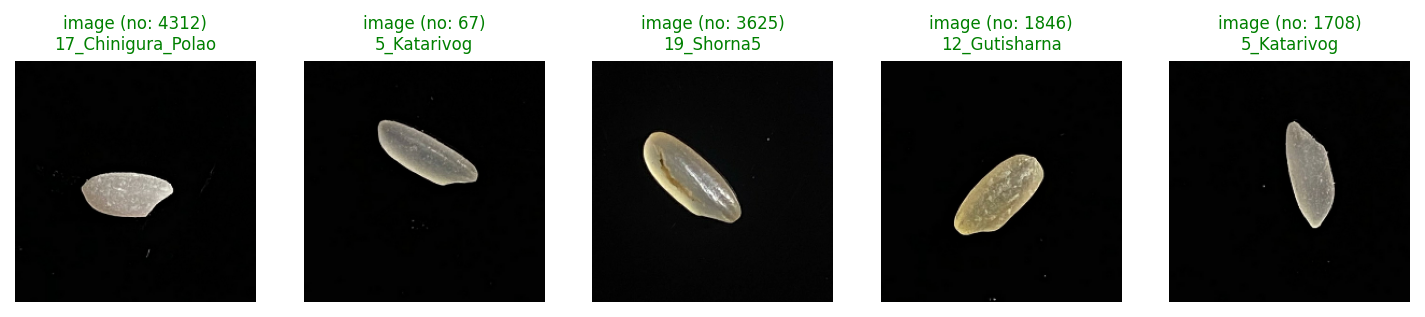

In [40]:
random_test_sample_with_prediction(SEED = 46)
random_test_sample_with_prediction(SEED = 585)
random_test_sample_with_prediction(SEED = 3)
random_test_sample_with_prediction(SEED = 896)